# Figure 3 — Timing effects

In [1]:
include("src/model.jl")
include("src/fig_timing.jl");

## 1. Data (Souza and Oberauer 2015)

In [2]:
using MATLAB

In [3]:
df_exp = DataFrame()

for subject in 1:36
    # read mat data
    data = read_matfile("../data/SouzaOberauer15/subjects/sub$(subject).mat")
    jval = jvalue(data["d"])
    
    # convert to df
    df = DataFrame(Dict(k => vec(v) for (k,v) in jval))
    df.subject = fill(subject, nrow(df))
    df.cond = Int.(df.cond)
    rename!(df, :err => :error)
    
    append!(df_exp, df)
end
;

In [4]:
# RIs: 1 or 3 seconds
ris = 1000 * sort(unique(df_exp.RI))
# ITIs: 0.5 or 7 seconds + 0.5s fixation cross
itis = 1000 * sort(unique(df_exp.ITI)) .+ 500

timing_conditions_exp = [
    TimingCondition("L - S", itis[2], ris[1]), 
    TimingCondition("S - S", itis[1], ris[1]), 
    TimingCondition("L - L", itis[2], ris[2]), 
    TimingCondition("S - L", itis[1], ris[2]),    
];

In [5]:
# mapping between experimental condition and meaning
df_exp_conditions = Dict(
    1 => "S - S",
    2 => "L - S",
    3 => "S - L",
    4 => "L - L",
)

# sort order for experimental condition
# e.g.: condition 1 should be ordered in 2nd position
df_exp_conditions_order = Dict(
    1 => 2,
    2 => 1,
    3 => 4,
    4 => 3,
)

sort!(df_exp, :cond, by=cond -> df_exp_conditions_order[cond])

# compute errors for each condition and subject
errors_exp = [
    [ggdf.error for ggdf in groupby(gdf, :subject)]
    for gdf in groupby(df_exp, :cond, sort=false)
];

In [6]:
using DataFramesMeta

calcvar(fun) = @chain df_exp begin
    @by([:subject, :cond], :var = fun(:error))
    @by(:cond, :var = mean(:var))
    @rorderby(df_exp_conditions_order[:cond])
    @rselect(:cond = df_exp_conditions[:cond], :var)
end

calcvar(var)
calcvar(cvar)
calcvar(cvar_bounded)
;

## 2. Simulation

In [7]:
nneurons = 1000
npopulations = 6

# add 1 second to RI (display duration)
timing_conditions_sim = [
    TimingCondition("L - S", itis[2], 1000+ris[1]), 
    TimingCondition("S - S", itis[1], 1000+ris[1]), 
    TimingCondition("L - L", itis[2], 1000+ris[2]), 
    TimingCondition("S - L", itis[1], 1000+ris[2]),    
];

In [8]:
# load existing run
using FileIO
errors_sim = load("data/fig3.jld2", "errors_sim");

In [ ]:
sim = Simulation(div(nneurons, npopulations), 16, npopulations; C=0.1);

# compute effective capacity
for condition in timing_conditions_sim
    cap = sim.C * (condition.ri + condition.iti) / condition.ri
    println("$(condition.name): $cap")
end

In [69]:
nsubjects = 5
nsamples = 1000
nrepeats = 1

errors_sim = [
    [zeros(nsamples) for _ in 1:nsubjects]
    for _ in timing_conditions_sim
]

for (i, condition) in enumerate(timing_conditions_sim)
    lg(condition.name)
    
    for subject in 1:nsubjects
        # get sequence
        cue = rand(1:sim.nstimuli)
        seq = getseq(sim, condition, cue; repeat=nrepeats)
        
        # run simulation
        reset!(sim, seed=SEEDS[subject])
        run!(sim, seq, warmup=5_000)
        
        # get samples
        samples = samplesim(sim, N=nsamples)
        probed = rand(sim.rng, 1:sim.npopulations)
        
        # compute error
        errors_sim[i][subject] = cdist.(samples[:,probed], sim.stimuli[cue])
    end
end
lg("done")
;

[2022-02-24T15:35:53.640] L - S
[2022-02-24T15:41:22.403] S - S
[2022-02-24T15:43:07.788] L - L
[2022-02-24T15:49:28.247] S - L
[2022-02-24T15:52:26.033] done


In [ ]:
# save data to file
#using FileIO
#save("data/fig3.jld2", "errors_sim", errors_sim)

## 3. Final figure

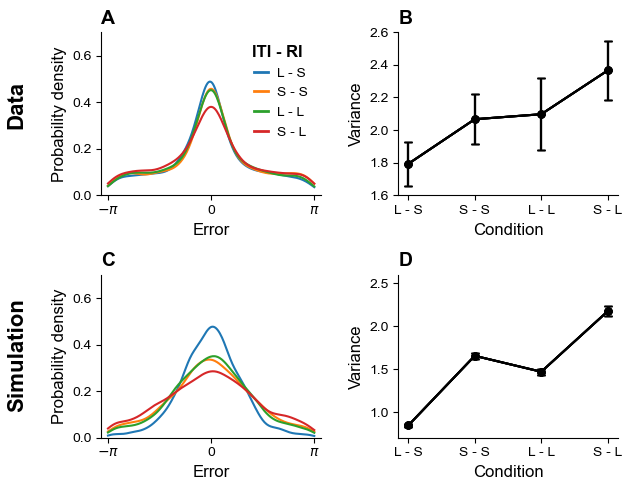

In [10]:
fig = figure("fig3_timing", figsize=(2/3 * 10, 5))

# A: error density
ax = subplot(221)
plt.title("A")
plot_timing_error!(ax, timing_conditions_exp, errors_exp; ylim=(0.0, 0.7))
leg = legend(title = "ITI - RI") |> legend_shorten_lines!
setp(leg.get_title(), fontsize=12, fontweight="bold")


# B: variance
ax = subplot(222)
plt.title("B")
plot_timing_variance!(ax, timing_conditions_exp, errors_exp; ylim=(1.6, 2.6))


# C: error density
ax = subplot(223)
plt.title("C")
plot_timing_error!(ax, timing_conditions_sim, errors_sim; ylim=(0.0, 0.7))


# D: error density
ax = subplot(224)
plt.title("D")
plot_timing_variance!(ax, timing_conditions_sim, errors_sim; ylim=(0.7, 2.6))

# Update the figure
fig.tight_layout(w_pad=2, rect=(0.05, 0, 0.95, 1)) # (left, bottom, right, top)

# add Data and Simulation annotations
annotate_data_simulation_side!();

In [11]:
fig.savefig("figs/fig3_timing.pdf")